In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cp -r /content/drive/Othercomputers/ThinkPad14/ai_motion_correction/utils/* /content

Import custom libraries/functions

In [3]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.9 MB/s 


In [4]:
from affine_network import AffineNeuralNetworkModel
from utils_dcm_2inputs import  DataGenerator, similarity_loss, loss_for_matrix, loss_for_vector       
from ManageData4NN import ManageData4NN

Import common libraries

In [5]:
import tensorflow as tf

import os, pickle, pydicom, time
import matplotlib.pyplot as plt

In [6]:
datadir = '/content/drive/MyDrive/Colab Notebooks/ai_motion/data'
training_files = pickle.load(open(os.path.join(datadir,'train_dcm','dcm_colab_training_set.pkl'), 'rb'))
validation_files = pickle.load(open(os.path.join(datadir,'train_dcm','dcm_colab_validation_set.pkl'), 'rb'))
testing_files = pickle.load(open(os.path.join(datadir,'train_dcm','dcm_colab_testing_set.pkl'),'rb'))

Create the model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 movable_input (InputLayer)     [(None, 128, 128, 1  0           []                               
                                28, 1)]                                                           
                                                                                                  
 fixed_input (InputLayer)       [(None, 128, 128, 1  0           []                               
                                28, 1)]                                                           
                                                                                                  
 input_pair (Concatenate)       (None, 128, 128, 12  0           ['fixed_input[0][0]',            
                                8, 2)                             'movable_input[0][0]']      

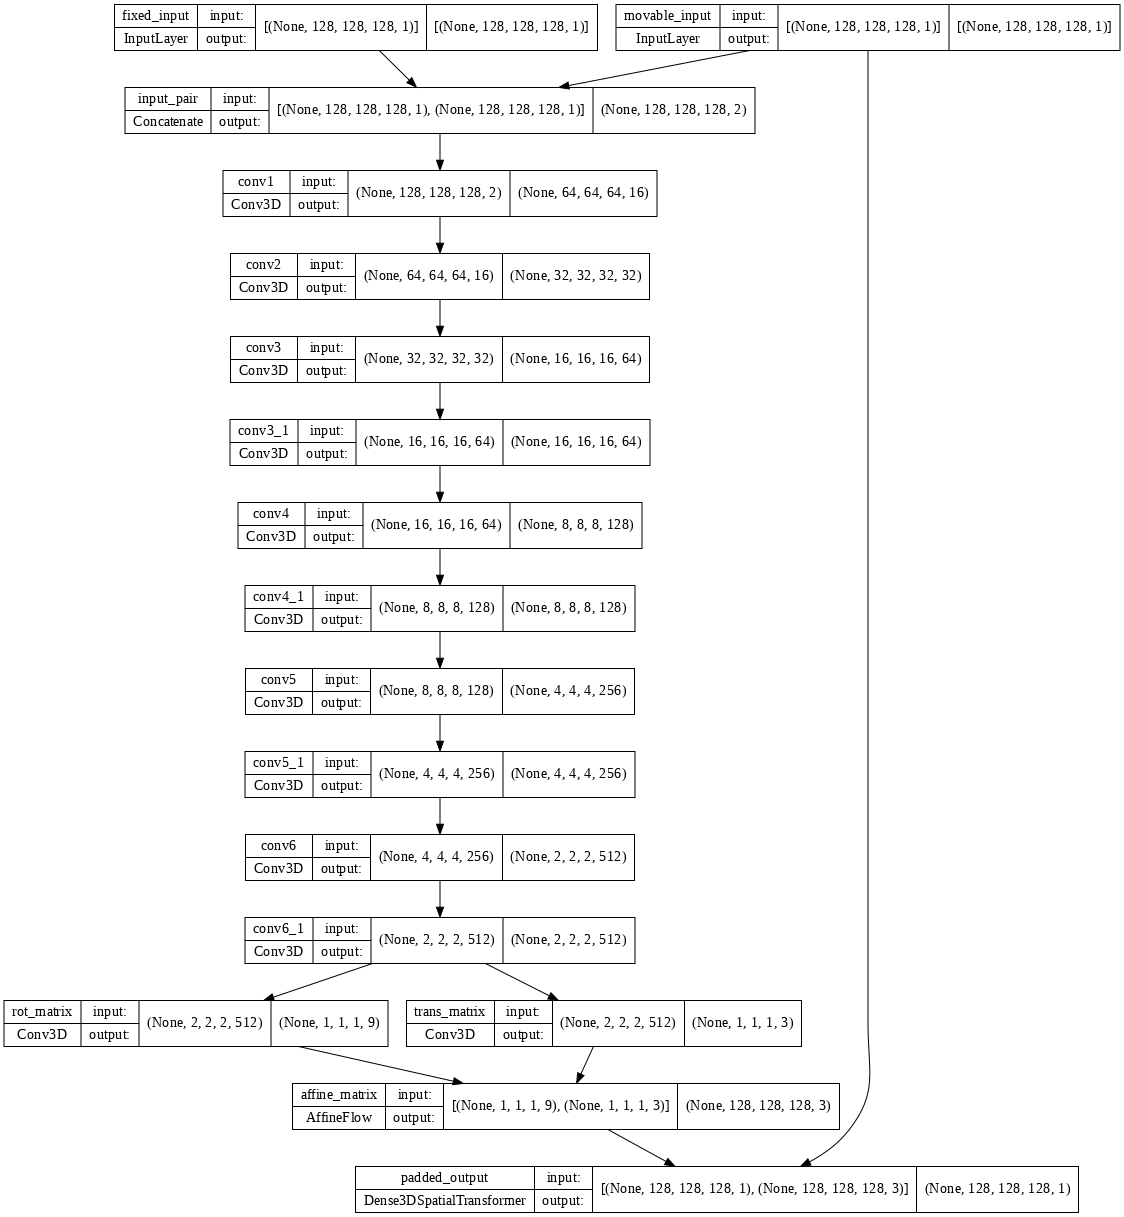

In [7]:
affine_mdl = AffineNeuralNetworkModel()

print(affine_mdl.summary())
tf.keras.utils.plot_model(affine_mdl, show_shapes=True, show_layer_names=True, dpi=72)

Train the model

In [8]:
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.5,
    staircase=True)

tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,name="Adam")


affine_mdl.compile(loss={'padded_output':similarity_loss,
                         'rot_matrix':loss_for_matrix,
                         'trans_matrix':loss_for_vector},
                         optimizer='Adam',run_eagerly=True)

In [ ]:
#number of epochs
epochs = 5
#batch size
batch_size = 8

#initialize the training generator
training_generator = DataGenerator(training_files, 
                                   batch_size=batch_size, 
                                   dim=(128, 128,128),
                                   n_channels=1, 
                                   shuffle=True)

#initialize the validation generator
validation_generator = DataGenerator(validation_files, 
                                   batch_size=batch_size, 
                                   dim=(128, 128,128),
                                   n_channels=1, 
                                   shuffle=True)

#fit the model
affine_mdl.fit(
    x = training_generator,
    validation_data = validation_generator, 
    epochs=epochs,
    verbose=2)

Epoch 1/5


Save the model

In [ ]:
#save the results of the training
with open(os.path.join(datadir,'results'), 'wb') as f:
    pickle.dump(affine_mdl.history, f)

affine_mdl.save(os.path.join(datadir,'DCM_5ep_8bs_2inputs'))

Test the model on the testing dataset

In [ ]:
#create an instance of the DataManager
testing_data_mgr = ManageData4NN()
#variable to list all the motion params
all_motion = []

for testing_pair in testing_files:
    
    start = time.time()
    #the target is in the second position
    testing_data_mgr.generate_target(pydicom.dcmread(testing_pair[1]))
    targ_input = testing_data_mgr.get_target()
    
    #movable for NN
    mov_input = testing_data_mgr.generate_movable(pydicom.dcmread(testing_pair[0]))
    #launch the model prediction
    
    output,W,b = affine_mdl.predict([targ_input,mov_input])

    interp_outut, motion = testing_data_mgr.process_otput(testing_data_mgr.get_orig_movable(),
                                                          W,
                                                          b)
    all_motion.append(motion)
    print('Elapsed time:',time.time()-start)

In [ ]:
plt.plot(all_motion,legend=['Trans X', 'Trans Y', 'Trans Z', 'Rot X', 'Rot Y', 'Rot Z'])